# Project 2: fire in the nature park

Laura Santa Cruz<br>
Intelligent data Analysis and Machine learning <br>
University of Potsdam 2024<br>

## 1. Introduction and problem setting

The administration of the nature park Montesinho wants to **predict wild fires based on wheather data of the Fire-Wheather-Index (FWI)**. The aim is to recognize the affected area and consequently the intensity of the imminent wild fire as early as possible in order to be able to adequatly assess the danger caused by the fire.

Data: 
    Collected from 517 wild fires containing following features: 

    X       X-coordinate of the fire in the park: 1 to 9 
    Y       Y-coordinate of the fire in the park: 2 to 9 
    month   month: ”jan“ to ”dec"
    day     day: ”mon“ bis ”sun“
    FFMC    FFMC index of the FWI system: 18.7 to 96.2
    DMC     DMC index of the FWI system: 1.1 bis 291.3  
    DC      DC index of the system: 7.9 bis 860.6
    ISI     ISI index of the FWI systems: 0.0 to 56.1
    temp    temperature in degrees Celsius: 2.2 to 33.3
    RH      relative humidity in %: 15 to 100
    wind    wind velocity in km/h: 0.4 to 9.4
    rain    rainfall in mm/m2: 0.0 to 6.4
    area    forest area that has been burnt in hectare (ha): 0.09 to 1090.84

Task:
    Develop a model that predicts the burnt forest **area** (our dependent variable) as accurately as possible from the given data.

### 1.1. Loading and inspection of the data

In order to have an overview of the dataset, some checks will be performed

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [74]:
fires = pd.read_csv('fires.csv')
print(fires)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


In [75]:
fires.describe() #for summary statistics

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Check for missing values:

In [76]:
if any(fires.isnull().sum()) != 0:
    print(fires.isnull().sum())
else: 
    print("No missing values.")


No missing values.


As we can see from this initial checks, the variables **'month' and 'day' are categorical** so we will need to enconde them in order to use them in the model. We can also plot these variables to visualize any months or days where fires happen more frequently:

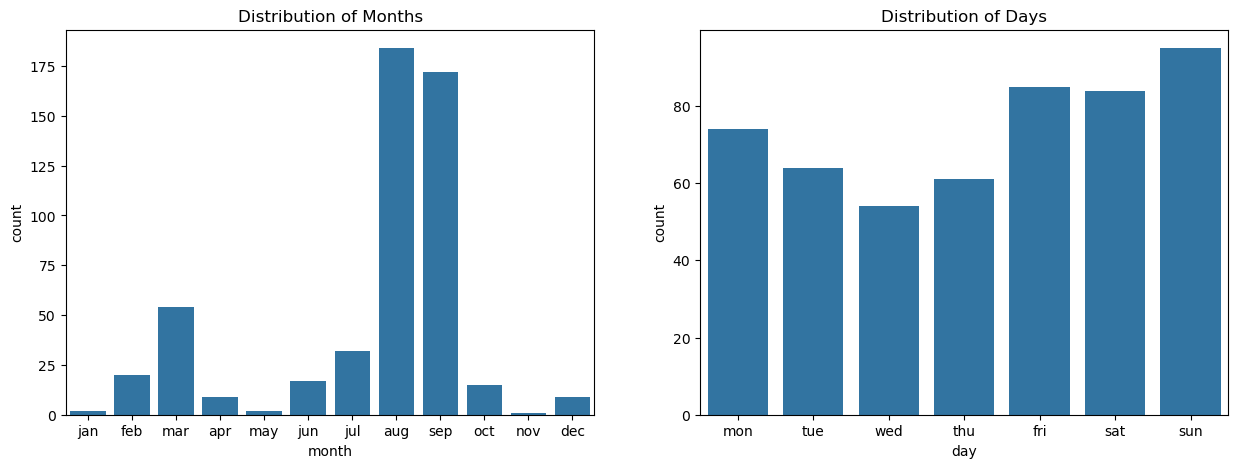

In [77]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Convert month and day columns to ordered categorical types (for plotting purposes)
fires['month'] = pd.Categorical(fires['month'], categories=month_order, ordered=True)
fires['day'] = pd.Categorical(fires['day'], categories=day_order, ordered=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(fires, x='month')
plt.title("Distribution of Months")

plt.subplot(1,2,2)
sns.countplot(fires, x='day')
plt.title("Distribution of Days")
plt.show()

From plotting 'month' we can see most fires happen during the months of August and September. With respect to 'day', the data is more evenly distributed, but most fires happen during the Fridays, Saturdays and Sundays. <br><br>
One-hot encoding will be used, so no misleading assumptions of magnitude are introduced and to ensure each category is treated independently:

In [78]:
fires = pd.get_dummies(fires, columns=['month','day'], drop_first=False, dtype=int)
fires.head(5)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_oct,month_nov,month_dec,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,day_sun
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,0,0,1,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,1,0,0,0,1,0,0,0,0,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,1,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,0,0,1,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,0,0,0,0,1


For the **numerical variables**, some like 'FFMC' (from 18.7 to 96.2) or 'DC' (from 7.9 to 860.6) have different varying scales so they need to be normalized. We can also check the distirbuion of the numerical data to look for outliers and non-normal distributions:

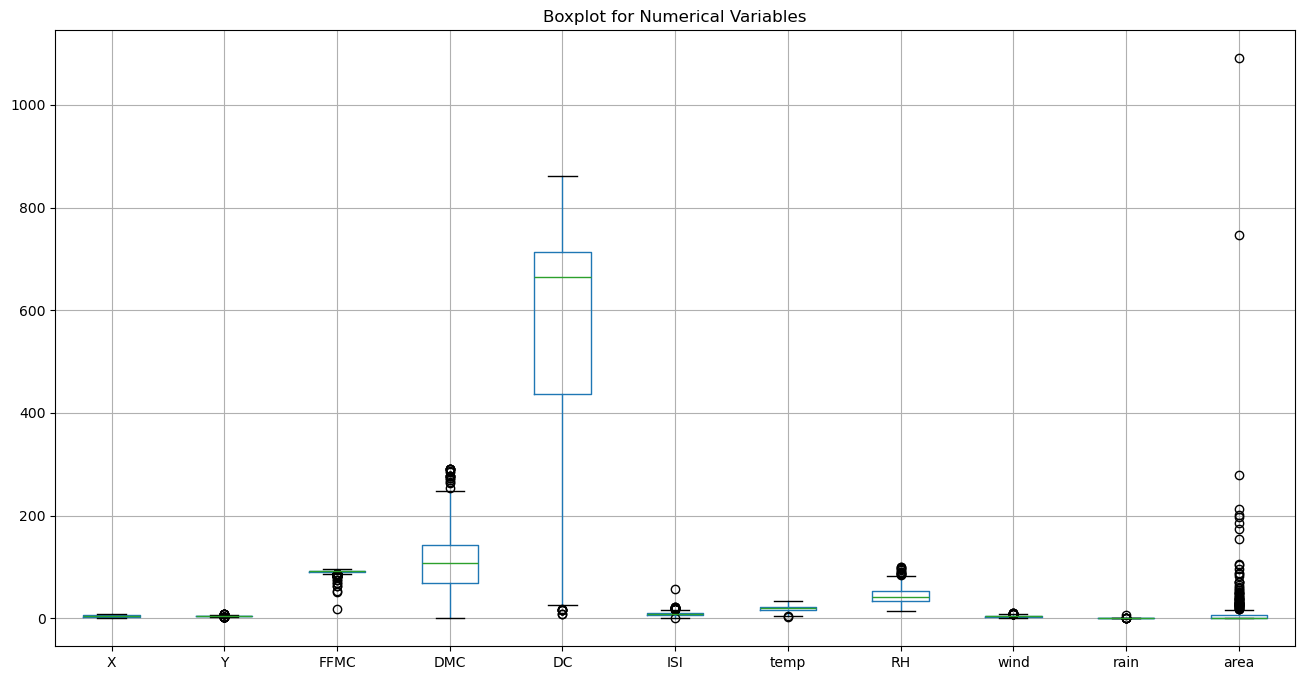

In [79]:
num_var = fires.loc[:, ['X','Y','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']]
plt.figure(figsize=(16, 8))  # Adjust the figure size to ensure clear visibility
num_var.boxplot()
plt.title('Boxplot for Numerical Variables')
plt.show()

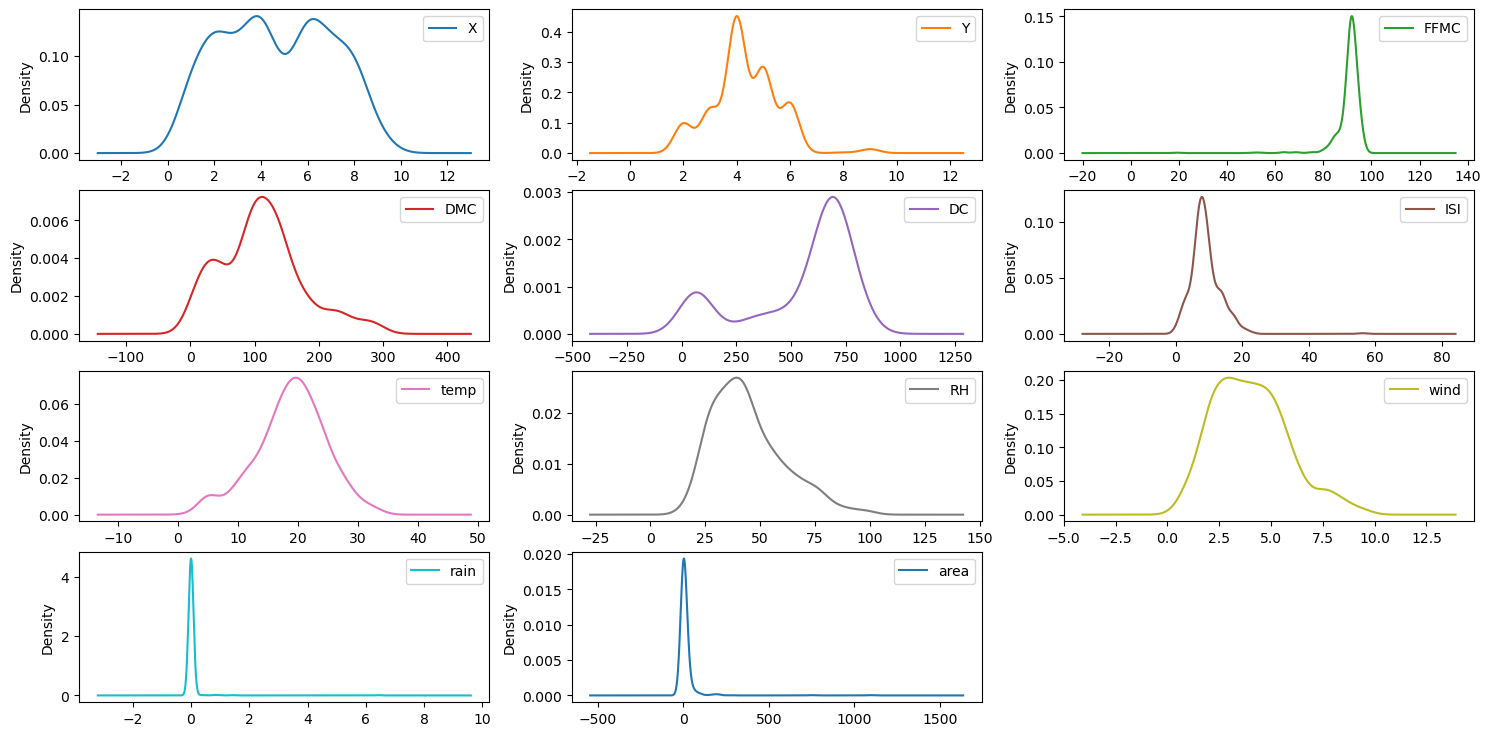

In [80]:
num_var.plot(kind="density", subplots=True, layout=[4,3], figsize=[18,9], sharex=False, ylabel=False)
plt.show()

As we can see from the plots, 'FFMC', 'ISI', 'rain', 'RH' and 'area' are skewed, so in order to be able to use linear regression, we will need to transform and normalize our data.<br>
It is also worth mentioning that our dependent variable 'area' contains many zero-value entries. 

## 2. Data preparation and normalization

### 2.1. Data transformations

In order to make the data more suitable for modelling, some transformations need to be applied.<br>
The log transformation is commonly used for right-skewed distributions and in this case it was used for the variables 'ISI', 'RH', 'rain' and 'area'. On the other hand, the power transformation was used for the variable 'FFMC' as it is more suitable for left-skewed distributions. 

In [81]:
fires['area_log'] = np.log1p(fires['area'])  # it applies log(1+x)
fires['rh_log'] = np.log1p(fires['RH'])
fires['rain_log'] = np.log1p(fires['rain'])
fires['isi_log'] = np.log1p(fires['ISI'])

fires['ffmc_power'] = fires.FFMC ** 12 # power transformation

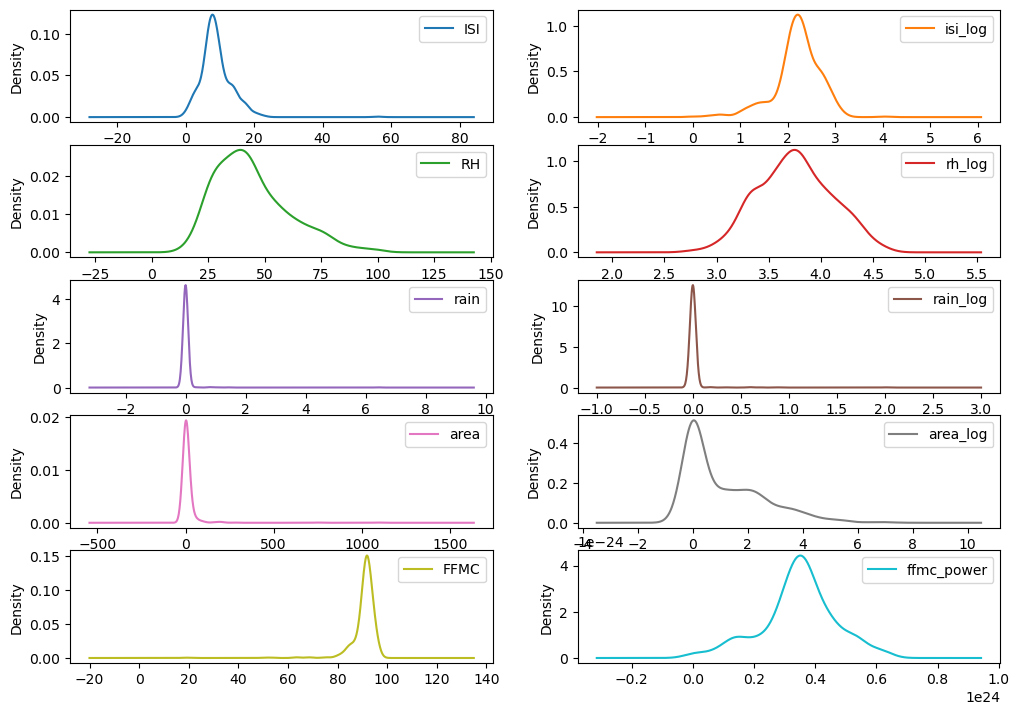

In [82]:
transf_var = fires.loc[:, ['ISI', 'isi_log', 'RH', 'rh_log', 'rain', 'rain_log', 'area', 'area_log', 'FFMC', 'ffmc_power']]
transf_var.plot(kind="density", subplots=True, layout=[7,2], figsize=[12,12], sharex=False, ylabel=False)
plt.show()

In [83]:
fires.drop(columns=['ISI','RH','rain','area','FFMC']) #keep the transformed values

,X,Y,DMC,DC,temp,wind,month_jan,month_feb,month_mar,month_apr,...,day_wed,day_thu,day_fri,day_sat,day_sun,area_log,rh_log,rain_log,isi_log,ffmc_power
0,7,5,26.2,94.3,8.2,6.7,0,0,1,0,...,0,0,1,0,0,0.000000,3.951244,0.000000,1.808289,1.683012e+23
1,7,4,35.4,669.1,18.0,0.9,0,0,0,0,...,0,0,0,0,0,0.000000,3.526361,0.000000,2.041220,3.058710e+23
2,7,4,43.7,686.9,14.6,1.3,0,0,0,0,...,0,0,0,1,0,0.000000,3.526361,0.000000,2.041220,3.058710e+23
3,8,6,33.3,77.5,8.3,4.0,0,0,1,0,...,0,0,1,0,0,0.000000,4.584967,0.182322,2.302585,3.535347e+23
4,8,6,51.3,102.2,11.4,1.8,0,0,1,0,...,0,0,0,0,1,0.000000,4.605170,0.000000,2.360854,2.571683e+23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,56.7,665.6,27.8,2.7,0,0,0,0,...,0,0,0,0,1,2.006871,3.496508,0.000000,1.064711,8.715291e+22
513,2,4,56.7,665.6,21.9,5.8,0,0,0,0,...,0,0,0,0,1,4.012592,4.276666,0.000000,1.064711,8.715291e+22
514,7,4,56.7,665.6,21.2,6.7,0,0,0,0,...,0,0,0,0,1,2.498152,4.262680,0.000000,1.064711,8.715291e+22
515,1,4,146.0,614.7,25.6,4.0,0,0,0,0,...,0,0,0,1,0,0.000000,3.761200,0.000000,2.509599,5.007996e+23


### 2.2. Normalization

Normalization is done in order to scale the values so that they can be comparable. In this case, we will use min-max normalization as it preserves the shapes of the distributions.<br>

In [101]:
from sklearn.preprocessing import MinMaxScaler

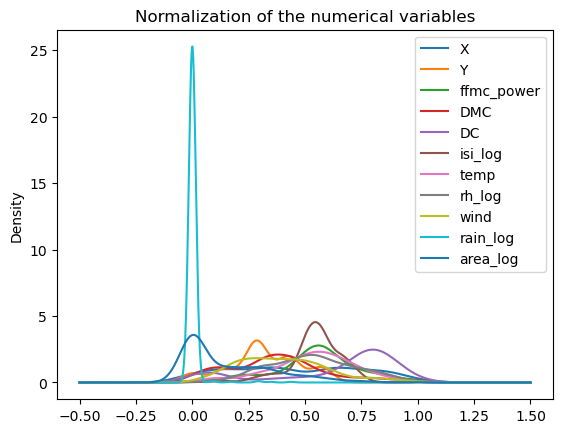

In [103]:
num_var = fires.loc[:, ['X','Y','ffmc_power', 'DMC', 'DC', 'isi_log', 'temp', 'rh_log', 'wind', 'rain_log', 'area_log']]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
fires_norm = pd.DataFrame(scaler.fit_transform(num_var), columns=num_var.columns)
fires_norm.plot(kind='density')
plt.title('Normalization of the numerical variables')
plt.show()

### 2.3. Check for correlations

## 3. Model creation

## 4. Summary

## 5. Conclusion